<a href="https://colab.research.google.com/github/MovindiM/MV_Course_Project/blob/main/Copy_MV_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from keras import callbacks
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU is available.')
else:
    print('GPU is not available. Please change the runtime type to GPU.')

GPU is available.


# Importing and Understanding the Dataset

In [ ]:
# Load the Oxford-IIIT Pet dataset from TensorFlow Datasets ---> without validation
dataset, info = tfds.load("oxford_iiit_pet", shuffle_files=True, as_supervised=True, with_info=True)

# Split into train and test sets
train_raw_data, test_raw_data = dataset["train"], dataset["test"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteY9RQ5E/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteY9RQ5E/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


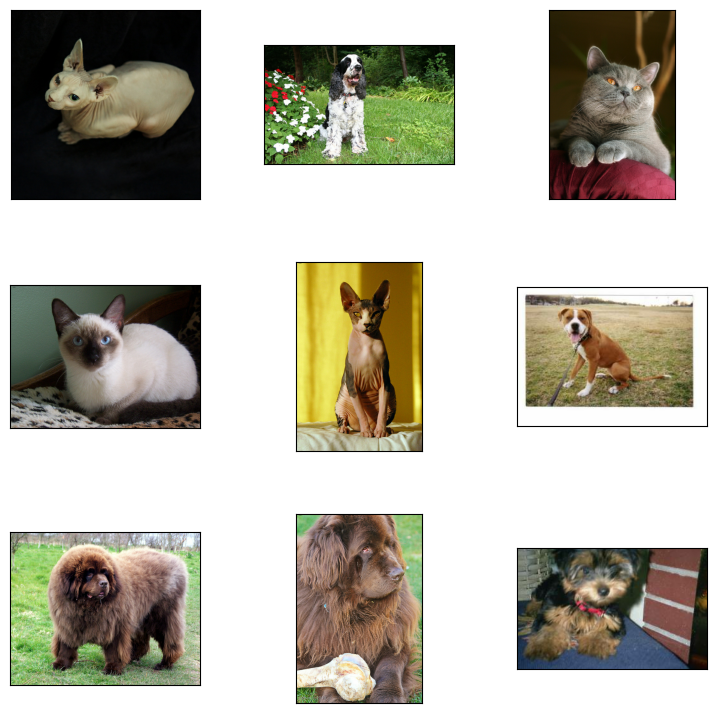

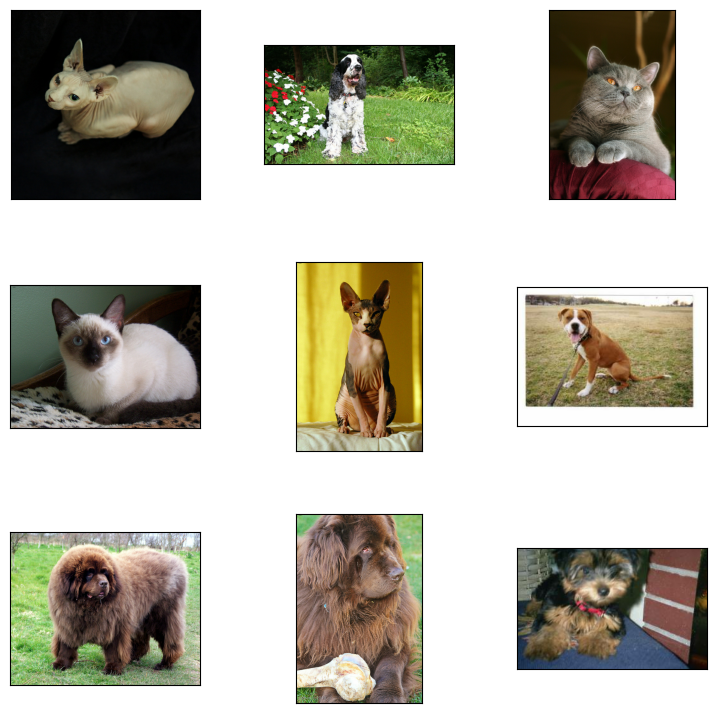

In [ ]:
# Display several examples of the dataset
tfds.show_examples(train_raw_data, info, image_key="image")

In [ ]:
# Get number of classes
num_classes = info.features["label"].num_classes
print("Number of classes:", num_classes)

Number of classes: 37


In [ ]:
# Get number of training examples and number of testing examples
num_train_samples = tf.data.experimental.cardinality(train_raw_data).numpy()
num_test_samples = tf.data.experimental.cardinality(test_raw_data).numpy()

print('Number of training samples:', num_train_samples)
print('Number of testing samples:', num_test_samples)

Number of training samples: 3680
Number of testing samples: 3669


Image shape:  (500, 334, 3)


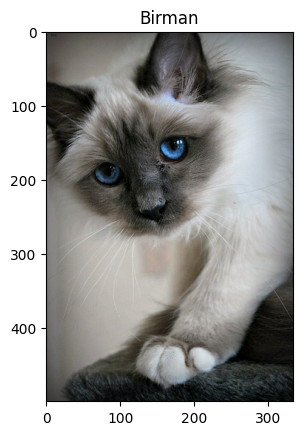

In [ ]:
# Function to obtain the name for the label integer
get_label_name = info.features['label'].int2str

# Build the custom function to display image and label name
def view_single_image(ds):
    image, label = next(iter(ds))
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label_name(label))

view_single_image(train_raw_data)

#Loading the ResNet50V2 Model

In [ ]:
# Load a pre-trained ResNet-50 model
pretrained_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Take a look at the pretrained model architecture
pretrained_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

#k-NN classification with the embeddings produced by the pretrained network

In [ ]:
# Create a function to extract image embeddings using a pre-trained model
def extract_embeddings(dataset, model):
    embeddings = []
    labels = []

    for image, label in tfds.as_numpy(dataset):
        image = tf.image.resize(image, (224, 224))  # Resize to match the input size of the pre-trained model
        image = tf.keras.applications.resnet_v2.preprocess_input(image)  # Preprocess input according to ResNet-50V2 requirements
        embedding = model.predict(np.expand_dims(image, axis=0))[0]
        pooled_embedding = np.mean(embedding, axis=(0, 1))  # Apply average pooling
        embeddings.append(pooled_embedding)
        labels.append(label)

    return np.array(embeddings), np.array(labels)

# Extract embeddings from the training set
train_embeddings, train_labels = extract_embeddings(train_raw_data, pretrained_model)

# Extract embeddings from the testing set
test_embeddings, test_labels = extract_embeddings(test_raw_data, pretrained_model)



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step


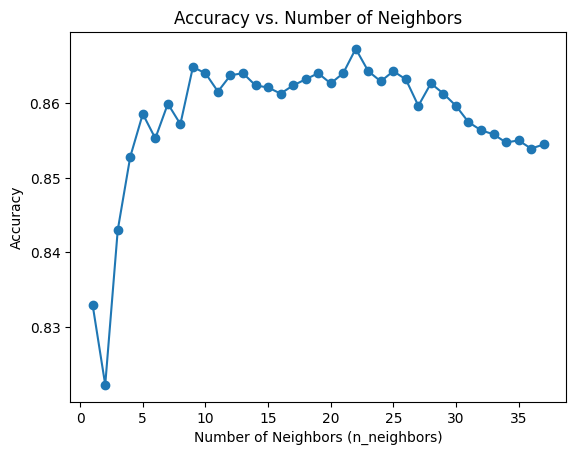

In [ ]:
# Checking the variation of accuracy with the number of neighbours

# Lists to store n_neighbors and corresponding accuracies
n_neighbors_values = list(range(1, 38))
accuracies = []

for i in n_neighbors_values:
    # Use k-NN classification
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(train_embeddings, train_labels)

    # Make predictions on the test set
    predictions = knn_classifier.predict(test_embeddings)

    # Evaluate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

# Plot the results
plt.plot(n_neighbors_values, accuracies, marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Find the maximum accuracy and the corresponding n_neighbors value
max_accuracy = max(accuracies)
max_accuracy_index = accuracies.index(max_accuracy)
max_n_neighbors = n_neighbors_values[max_accuracy_index]

# Print the maximum accuracy and the corresponding n_neighbors value
print('Maximum accuracy:', max_accuracy)
print('Corresponding n_neighbors:', max_n_neighbors)


Maximum accuracy: 0.8672662850913055
Corresponding n_neighbors: 22


In [ ]:
# Use k-NN classification
knn_classifier = KNeighborsClassifier(n_neighbors=max_n_neighbors)
knn_classifier.fit(train_embeddings, train_labels)

# Make predictions on the test set
test_predictions = knn_classifier.predict(test_embeddings)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy on the test set: {accuracy}")

Accuracy on the test set: 0.8672662850913055


Test accuracy: 0.8672662850913055


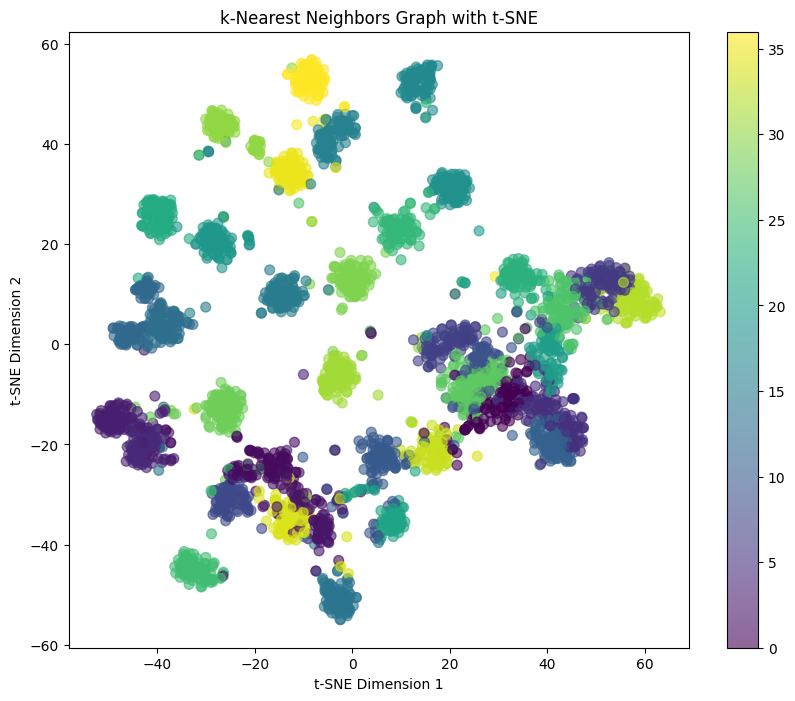

In [ ]:
from sklearn.manifold import TSNE
# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(test_embeddings)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print('Test accuracy:', test_accuracy)

# Plot k-Nearest Neighbors graph with t-SNE reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_predictions, cmap='viridis', s=50, alpha=0.6, marker='o')
plt.title('k-Nearest Neighbors Graph with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

# Partitioning training sample for train and validation

In [ ]:
# Get the total number of samples in the test dataset
total_samples = tf.data.experimental.cardinality(train_raw_data).numpy()

# Calculate the number of samples for validation (10%)
validation_samples = int(0.1 * total_samples)

# Create a validation dataset
val_raw_data = train_raw_data.take(validation_samples)

# Create a test dataset by skipping the validation samples
train_raw_data = train_raw_data.skip(validation_samples)

In [ ]:
# Get number of training examples and number of testing examples
num_train_samples = tf.data.experimental.cardinality(train_raw_data).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw_data).numpy()
num_test_samples = tf.data.experimental.cardinality(test_raw_data).numpy()

print('Number of training samples:', num_train_samples)
print('Number of validating samples:', num_val_examples)
print('Number of testing samples:', num_test_samples)

Number of training samples: 3312
Number of validating samples: 368
Number of testing samples: 3669


# Prepairing Datasets and Data Augmentation

In [ ]:
# Resize train and test set to match the input size of the pre-trained model
IMG_SIZE = 224

train_ds = train_raw_data.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = val_raw_data.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
test_ds = test_raw_data.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(factor=0.1),
])

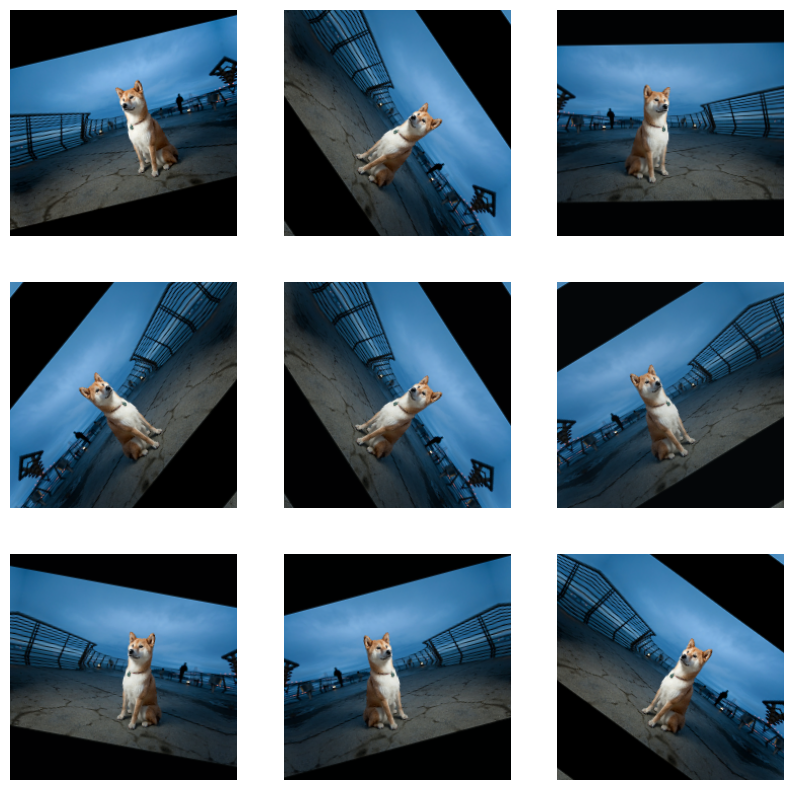

In [ ]:
# Apply data augmentation layers to the same image and see the result
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')

In [ ]:
# batch the data and use prefetching
BATCH_SIZE = 32

train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# Freezing the pretrained model

In [ ]:
# Freeze the pretrained model
pretrained_model.trainable = False

In [ ]:
pretrained_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

# Rebuild top layers

In [ ]:
# Build the entire model --> with data augmentation
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = pretrained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
predictions =  tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, predictions)

In [ ]:
# Take a look at the model architecture
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

## Using Learning Rate Scheduler

In [ ]:
# Using learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Earlystopping

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

#Compile the model and training

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
round(model.optimizer.lr.numpy(), 5)

1e-04

In [ ]:
# Fit the model
number_of_epochs = 20

history = model.fit(train_ds, epochs=number_of_epochs, validation_data=val_ds, callbacks=[lr_schedule, earlystopping], verbose=1)

Epoch 1/20
103/103 [==============================] - 21s 149ms/step - loss: 2.5973 - sparse_categorical_accuracy: 0.3307 - val_loss: 1.5851 - val_sparse_categorical_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 2/20
103/103 [==============================] - 14s 134ms/step - loss: 0.9546 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.8453 - val_sparse_categorical_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 3/20
103/103 [==============================] - 14s 130ms/step - loss: 0.5877 - sparse_categorical_accuracy: 0.8495 - val_loss: 0.6101 - val_sparse_categorical_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 4/20
103/103 [==============================] - 14s 132ms/step - loss: 0.4160 - sparse_categorical_accuracy: 0.8932 - val_loss: 0.4979 - val_sparse_categorical_accuracy: 0.8494 - lr: 1.0000e-04
Epoch 5/20
103/103 [==============================] - 15s 141ms/step - loss: 0.3197 - sparse_categorical_accuracy: 0.9217 - val_loss: 0.4412 - val_sparse_categorical_accuracy: 0.8551 - lr: 1.0000e-04


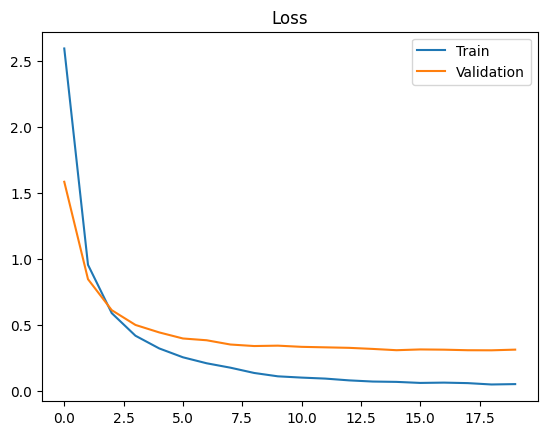

In [ ]:
# Plot the loss of the training set over epochs
loss_train_curve = history.history["loss"]
val_loss_train_curve = history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(val_loss_train_curve, label = "Validation")
plt.legend(loc = "upper right")
plt.title("Loss")
plt.show()

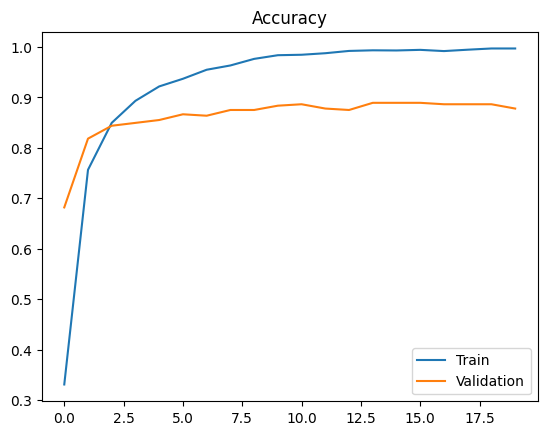

In [ ]:
# Plot the accuracy of the training set over epochs
acc_train_curve = history.history["sparse_categorical_accuracy"]
val_acc_train_curve = history.history["val_sparse_categorical_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(val_acc_train_curve, label = "Validation")
plt.legend(loc = "lower right")
plt.title("Accuracy")
plt.show()

# Evaluate the model on test set

In [ ]:
# Evaluate the model on test dataset
preds = model.predict(test_ds)
result = model.evaluate(test_ds)

114/114 [==============================] - 15s 127ms/step - loss: 0.4439 - sparse_categorical_accuracy: 0.8638


# Fine Tuning

In [ ]:
# Unfreeze the pretrained model
pretrained_model.trainable = True

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
# Continue training the model
fine_tune_epochs = 10
history_fine = model.fit(train_ds, epochs=fine_tune_epochs, validation_data=val_ds, callbacks=[earlystopping], verbose=1)

Epoch 1/10
103/103 [==============================] - 64s 340ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.2939 - val_sparse_categorical_accuracy: 0.8949
Epoch 2/10
103/103 [==============================] - 32s 307ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.2841 - val_sparse_categorical_accuracy: 0.8864
Epoch 3/10
103/103 [==============================] - 32s 305ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.2875 - val_sparse_categorical_accuracy: 0.8920
Epoch 4/10
103/103 [==============================] - 33s 309ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.2603 - val_sparse_categorical_accuracy: 0.8949
Epoch 5/10
103/103 [==============================] - 34s 321ms/step - loss: 0.0086 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2601 - val_sparse_categorical_accuracy: 0.9062
Epoch 6/10
103/103 [==============================] - 33s 308ms/step - loss: 0.0068 -

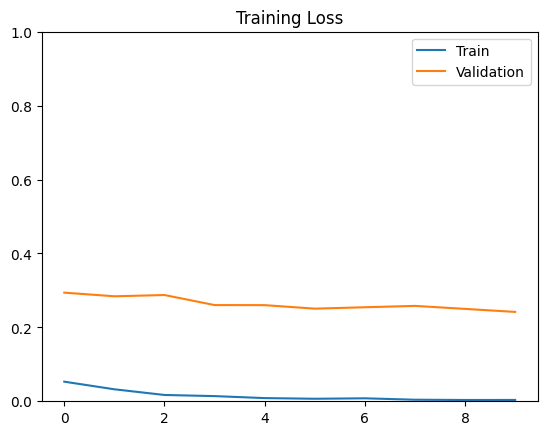

In [ ]:
# Plot the loss of the training set over epochs
loss_train_curve = history_fine.history["loss"]
val_loss_train_curve = history_fine.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(val_loss_train_curve, label = "Validation")
plt.ylim(0, 1)
plt.legend(loc="upper right")
plt.title("Training Loss")
plt.show()

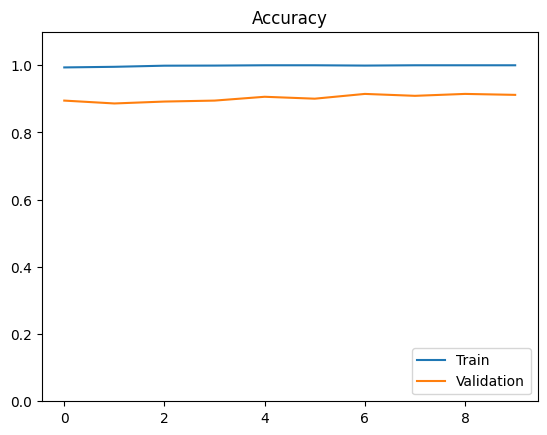

In [ ]:
# Plot the accuracy of the training set over epochs
acc_train_curve = history_fine.history["sparse_categorical_accuracy"]
val_acc_train_curve = history_fine.history["val_sparse_categorical_accuracy"]
plt.plot(acc_train_curve, label="Train")
plt.plot(val_acc_train_curve, label = "Validation")
plt.ylim(0, 1.1)
plt.legend(loc="lower right")
plt.title("Accuracy")
plt.show()

In [ ]:
# Evaluate the model on test dataset
preds = model.predict(test_ds)
result = model.evaluate(test_ds)

114/114 [==============================] - 14s 123ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.8780
